In [6]:
import numpy as np
from datetime import datetime

from astropy import units as u
from astropy import time
from astropy.coordinates import EarthLocation, AltAz, SkyCoord, ITRS, GCRS
from astropy.constants import R_earth

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.ndimage import uniform_filter1d
from scipy.optimize import root_scalar

import cysgp4

from pycraf import conversions as cnv
from pycraf.antenna import ras_pattern
from pycraf.geometry import true_angular_distance

from scepter import tleforger
from scepter.antenna import s_1528_rec1_2_pattern
from scepter.skynet import pointgen, pointgen_S_1586_1
from scepter.earthgrid import generate_hexgrid_full,calculate_footprint_size, trunc_hexgrid_to_impactful
from scepter import satsim
from scepter import scenario
from scepter.gpu_accel import true_angular_distance_auto

from tqdm.auto import tqdm


In [7]:
# This is rough estimate of memory pressure in MB. Will vary depending on size of dimentions, 
# so require manual adjustment at this stage
_TIMESTAMP_MEM=512
# Indicate how much memory could be allocated for the script
_AVAILABLE_MEM=32*1024
_BULK_TIMESTAMPS=int(np.min(np.floor(_AVAILABLE_MEM/_TIMESTAMP_MEM)))
print(f"Maximum number of simultaneous timesteps is {_BULK_TIMESTAMPS}")

_STORAGE_FILENAME="simulation_results.h5"
scenario.init_simulation_results(_STORAGE_FILENAME)

FREQUENCY = 10.7 * u.GHz
wavelength = FREQUENCY.to(u.m, equivalencies=u.spectral())
cysgp4.set_num_threads(scenario.current_thread_count)
satsim.nb_set_num_threads(scenario.current_thread_count)

Maximum number of simultaneous timesteps is 64


### GENERATE TIME STAMPS ###

In [8]:
start_time = time.Time(datetime(2025, 1, 1, 0, 0, 0))
end_time =  time.Time(datetime(2025, 1, 1, 0, 3, 0))
timestep = 1 # steps in seconds
time_batches=scenario.generate_simulation_batches(start_time, end_time, timestep, _BULK_TIMESTAMPS)

n_times = len(time_batches['times'][0])  # total frames per batch
n_batches = len(time_batches['times'])  # total frames per batch
print(f'Simulation will include approximately {n_times} time stamps for each of {n_batches} batches')

Simulation will include approximately 64 time stamps for each of 3 batches


### DEFINE SATELLITE SYSTEM

In [9]:
belt_names = []
belt_sats = []
altitudes = []
max_deviation_angles = []
tle_list = []
min_elevations = []
max_betas = []
belt_name='SystemC_Belt_1'
num_sats_per_plane = 40
plane_count = 18
altitude = 1200 * u.km
eccentricity = 0.0
inclination_deg = 87.9 * u.deg
argp_deg = 0.0 * u.deg
RAAN_min = 0 * u.deg
RAAN_max = 180 * u.deg
max_deviation_angle = np.arcsin(R_earth / (R_earth + altitude)).to(u.deg)
min_elevation = 30 * u.deg
max_beta = np.arcsin((R_earth*np.sin(90*u.deg+min_elevation))/(R_earth+altitude)).to(u.deg)
Nco=1
Nbeam=16


System_C_tle_list = tleforger.forge_tle_belt(belt_name=belt_name, num_sats_per_plane=num_sats_per_plane, 
                                            plane_count=plane_count, RAAN_min=RAAN_min, 
                                            RAAN_max=RAAN_max, altitude=altitude, eccentricity=eccentricity, inclination_deg=inclination_deg, 
                                            argp_deg=argp_deg, adjacent_plane_offset=False)



belt_names.append(belt_name)
belt_sats.append(len(System_C_tle_list))
altitudes.append(altitude)
max_deviation_angles.append(max_deviation_angle)
tle_list.extend(System_C_tle_list)
min_elevations.append(min_elevation)
max_betas.append(max_beta)

belt_sats = np.array(belt_sats)
altitudes = np.array(altitudes, dtype=object)
max_deviation_angles = np.array(max_deviation_angles, dtype=object)
tle_list = np.array(tle_list, dtype=object)
min_elevations = np.array(min_elevations, dtype=object)
max_betas = np.array(max_betas, dtype=object)

format_func = np.vectorize(lambda x: f"{x:.2f}")
n_sats = len(tle_list)
print(f'Total number of satellites: {n_sats}')
print(f'Defined belts are {belt_names} with number of sats per belt {belt_sats} at altitudes {format_func(altitudes)}.\n'+
    f'Their absolute max offset β angles are {format_func(max_deviation_angles)}\n'+
    f'With min elevation {format_func(min_elevations)} their max offset β angles are {format_func(max_betas)}')

Total number of satellites: 720
Defined belts are ['SystemC_Belt_1'] with number of sats per belt [720] at altitudes ['1200.00 km'].
Their absolute max offset β angles are ['57.31 deg']
With min elevation ['30.00 deg'] their max offset β angles are ['46.79 deg']


### Set up RAS station

In [10]:
latitude = -30.712777 * u.deg
longitude = 21.443611 * u.deg
elevation = 1052.0 * u.m
SKAO=cysgp4.PyObserver(longitude.value,latitude.value,elevation.to(u.km).value)

SKAO_ant_diam = 15 * u.m
observer_list=[SKAO]
print(f'RAS stations defined as {observer_list}')
highest_altitude = np.max(altitudes)
slant_distance_max = (np.sqrt((R_earth + highest_altitude)**2 - (R_earth)**2)).to(u.km)
max_deviation_angle = np.arcsin(R_earth / (R_earth + highest_altitude)).to(u.deg)
print(f'Highest altitude is {highest_altitude:.2f}\nMaximum slant path possible {slant_distance_max:.2f} at {max_deviation_angle:.2f} offset β angle')

RAS stations defined as [<PyObserver: 21.4436d, -30.7128d, 1.0520km>]
Highest altitude is 1200.00 km
Maximum slant path possible 4092.36 km at 57.31 deg offset β angle


### Generate Earth cells

In [11]:

altitude_ex = highest_altitude
off_nadir_ex = 0 * u.deg
pattern_kwargs_ex = {
    'D': 1.0 * u.m,
    'wavelength': (10.7 * u.GHz).to(u.m, u.spectral()),
    'LN': -20 * cnv.dB
}
footprint_low = calculate_footprint_size(
    antenna_gain_func=s_1528_rec1_2_pattern,
    altitude=altitude_ex,
    off_nadir_angle=off_nadir_ex,
    earth_model='spherical',
    **pattern_kwargs_ex
)
print(f"Footprint size is {footprint_low.to(u.km)}")
# point_spacing = footprint_low

point_spacing = 1000*u.km
grid_lons, grid_lats, _ = generate_hexgrid_full(point_spacing)
CELL_LIST=[]
for i in range (np.size(grid_lons)):
    CELL=cysgp4.PyObserver(grid_lons[i],grid_lats[i],0)    
    CELL_LIST.append(CELL)
mask = trunc_hexgrid_to_impactful(grid_lons,grid_lats,highest_altitude,min_elevation,latitude,longitude,elevation)
active_grid_lons=grid_lons[mask]
active_grid_lats=grid_lats[mask]
ACTIVE_CELL_LIST=[]
for i in range (np.size(active_grid_lons)):
    ACTIVE_CELL=cysgp4.PyObserver(active_grid_lons[i],active_grid_lats[i],0)    
    ACTIVE_CELL_LIST.append(ACTIVE_CELL)

print(f'Total number of cells is {np.size(grid_lons)}')
print(f'Total number of impactful cells is {np.size(active_grid_lons)}')

if(len(observer_list)==1):
    observer_list.extend(ACTIVE_CELL_LIST)

Footprint size is 40.66026104377274 km
Total number of cells is 642
Total number of impactful cells is 97


### Simualte satellite movement

In [12]:
observer_list=np.array(observer_list)
#Reshaping the inputs
observers_new=observer_list[np.newaxis, :, np.newaxis]
tles_new=tle_list[np.newaxis, np.newaxis, :]

# Simulation block

In [ ]:
for i in (pbar := tqdm(range(n_batches), desc='Processing time slices:')):
    # Prepare time slice    
    local_times = time_batches['times'][i]
    n_local_times = len(local_times)
    mjds_new=local_times.mjd[:, np.newaxis, np.newaxis]
    # Simualte satellite movement
    pbar.set_description("Processing satellite positions")
    result = cysgp4.propagate_many(mjds_new, 
                            tles_new, 
                            observers_new, 
                            do_eci_pos=False, 
                            do_eci_vel=False, 
                            do_geo=False, 
                            do_topo=True,
                            do_obs_pos=False,
                            do_sat_azel=True,
                            do_sat_rotmat=False,
                            sat_frame='xyz')
    sat_topo=result['topo'] # anges to satellites in local observers' frames
    sat_azel=result['sat_azel'] # anges to observer in local satellites' frames
    # Shape is (times, observers, satellites,...)

    # -------------------- BEAM SELECTION ----------------
    pbar.set_description("Processing beams")
    sat_cell_links = satsim.compute_sat_cell_links_auto(sat_topo, min_elevation, Nco, cell_observer_offset=1, Nbeam=16)
    no_link_mask = (sat_cell_links == -1)

    # -------------------- ANGLE CALCULATION ----------------
    pbar.set_description("Processing angles")
    # Calculate satellite antennas off-axis angles. This block uses satellites as reference points.
    # RAS station azimuth/elevation in satellites' reference frames (shape: (n_time, n_satellites))
    ras_az = sat_azel[:,0,:,0]
    ras_el = sat_azel[:,0,:,1]

    # Earthgrid cells azimuth/elevation in satellites' reference frames (shape: (n_time, n_cell, n_satellites))
    sat_antenna_az = sat_azel[:,-np.size(active_grid_lons):,:,0]
    sat_antenna_el = sat_azel[:,-np.size(active_grid_lons):,:,1]    

    # For cells, extract the satellite antenna azimuth and elevation corresponding to the linked satellites.
    # The outputs below will have shape (n_time, n_cells, Nco).
    selected_sat_antenna_az = np.take_along_axis(sat_antenna_az, sat_cell_links, axis=-1)
    selected_sat_antenna_el = np.take_along_axis(sat_antenna_el, sat_cell_links, axis=-1)

    # Expand ras_az and ras_el to (n_time, 1, n_satellites) to broadcast over cells.
    selected_ras_az = np.take_along_axis(ras_az[:, np.newaxis, :], sat_cell_links, axis=-1)
    selected_ras_el = np.take_along_axis(ras_el[:, np.newaxis, :], sat_cell_links, axis=-1)

    offset_deg_gtx_selected = true_angular_distance_auto(selected_ras_az * u.deg, 
                                                    (90 - selected_ras_el) * u.deg,
                                                    selected_sat_antenna_az * u.deg, 
                                                    (90 - selected_sat_antenna_el) * u.deg
                                                    )

    # Calculate RAS antenna off-axis angles for different telescope pontings and satellite positions. The shape is (timestamp, sky_cell, satellite). 
    # Do not confuse sky cells with satellite coverage cells provided by earthgrid module. This block uses RAS station as a reference point.
    # satellite azimuth/elevation in RAS station reference frame from sat_topo (shape: (n_time, n_satellites))
    sat_position_az = sat_topo[:, 0, :, 0]
    sat_position_el = sat_topo[:, 0, :, 1]

    selected_sat_position_az = np.take_along_axis(sat_position_az[:, np.newaxis, :], sat_cell_links, axis=-1)
    selected_sat_position_el = np.take_along_axis(sat_position_el[:, np.newaxis, :], sat_cell_links, axis=-1)

    # Generate sky cell pointings
    tel_az, tel_el, _ = pointgen_S_1586_1(n_local_times)

    offset_deg_grx = true_angular_distance_auto(tel_az[:, :, np.newaxis, np.newaxis]*u.deg, tel_el[:, :, np.newaxis, np.newaxis]*u.deg, 
                                        selected_sat_position_az[:, np.newaxis, :, :]*u.deg, selected_sat_position_el[:, np.newaxis, :, :]*u.deg)
    
    # -------------------- POWER CALCULATION ----------------
    pbar.set_description("Processing power")    
    # gtx and distances_earthgrid_cells_trunc shapes will be (n_time, n_cells, Nco)
    distances_earthgrid_cells_trunc = np.take_along_axis(sat_topo[:, 1:, :, 2], sat_cell_links, axis=-1)*u.km
    Gtx, Gm, _ = s_1528_rec1_2_pattern(offset_deg_gtx_selected)


    powerflux = -121 * cnv.dB_W_m2 - 10*np.log10(Nco)
    Ptx = cnv.ptx_from_powerflux(powerflux, distances_earthgrid_cells_trunc, Gm)[:,np.newaxis,:,:]
    Gtx = Gtx[:,np.newaxis,:,:]
    Grx = ras_pattern(offset_deg_grx, SKAO_ant_diam, wavelength)
    distances_2RAS = sat_topo[:, 0, :, 2] * u.km
    distances_2RAS_selected = np.take_along_axis(distances_2RAS[:, np.newaxis, :], sat_cell_links, axis=-1)[:,np.newaxis,:,:]
    satellite_elevation_from_RAS = np.take_along_axis(sat_topo[:,0,:,1][:, np.newaxis, :], sat_cell_links, axis=-1)

    # target shape is (timestamp,sky_cell,earth_grid_cell, Nco)
    Prx = cnv.prx_from_ptx(Ptx, Gtx, Grx, distances_2RAS_selected, FREQUENCY)

    elev_mask = (satellite_elevation_from_RAS < 0)
    combined_mask = no_link_mask | elev_mask
    mask_full = np.broadcast_to(combined_mask[:,np.newaxis,:,:], Prx.shape)
    Prx[mask_full]= np.nan * u.W

    powerflux_2RAS = cnv.powerflux_from_prx(Prx[:,0,:,:],FREQUENCY, Grx[:,0,:,:])
    total_Prx=np.nansum(Prx, axis=2)    

    times_array = local_times.mjd
    satellite_elevation_from_RAS[no_link_mask]=-1001
    pbar.set_description("Storing results")
    scenario.append_simulation_results(_STORAGE_FILENAME, times_array, total_Prx, satellite_elevation_from_RAS, powerflux_2RAS)
    if i == n_batches-1:
        pbar.set_description("Finished")

Processing time slices::   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
print(total_Prx.shape)

(53, 2334, 1)


In [ ]:
print(f'Total number of impactful cells is {np.size(active_grid_lons)}')
links = sat_cell_links[0]
flat = links.ravel()
unique_sats, counts = np.unique(flat, return_counts=True)
for sat_id, cnt in zip(unique_sats, counts):
    print(f"Satellite {sat_id}: connected to {cnt} cells")

Total number of impactful cells is 97
Satellite 25: connected to 1 cells
Satellite 65: connected to 1 cells
Satellite 272: connected to 1 cells
Satellite 315: connected to 1 cells
Satellite 317: connected to 1 cells
Satellite 353: connected to 2 cells
Satellite 355: connected to 2 cells
Satellite 356: connected to 2 cells
Satellite 357: connected to 1 cells
Satellite 393: connected to 1 cells
Satellite 395: connected to 2 cells
Satellite 396: connected to 1 cells
Satellite 398: connected to 1 cells
Satellite 399: connected to 1 cells
Satellite 401: connected to 1 cells
Satellite 433: connected to 1 cells
Satellite 434: connected to 1 cells
Satellite 436: connected to 2 cells
Satellite 438: connected to 1 cells
Satellite 439: connected to 2 cells
Satellite 440: connected to 4 cells
Satellite 471: connected to 1 cells
Satellite 475: connected to 1 cells
Satellite 477: connected to 2 cells
Satellite 478: connected to 2 cells
Satellite 481: connected to 1 cells
Satellite 482: connected to 

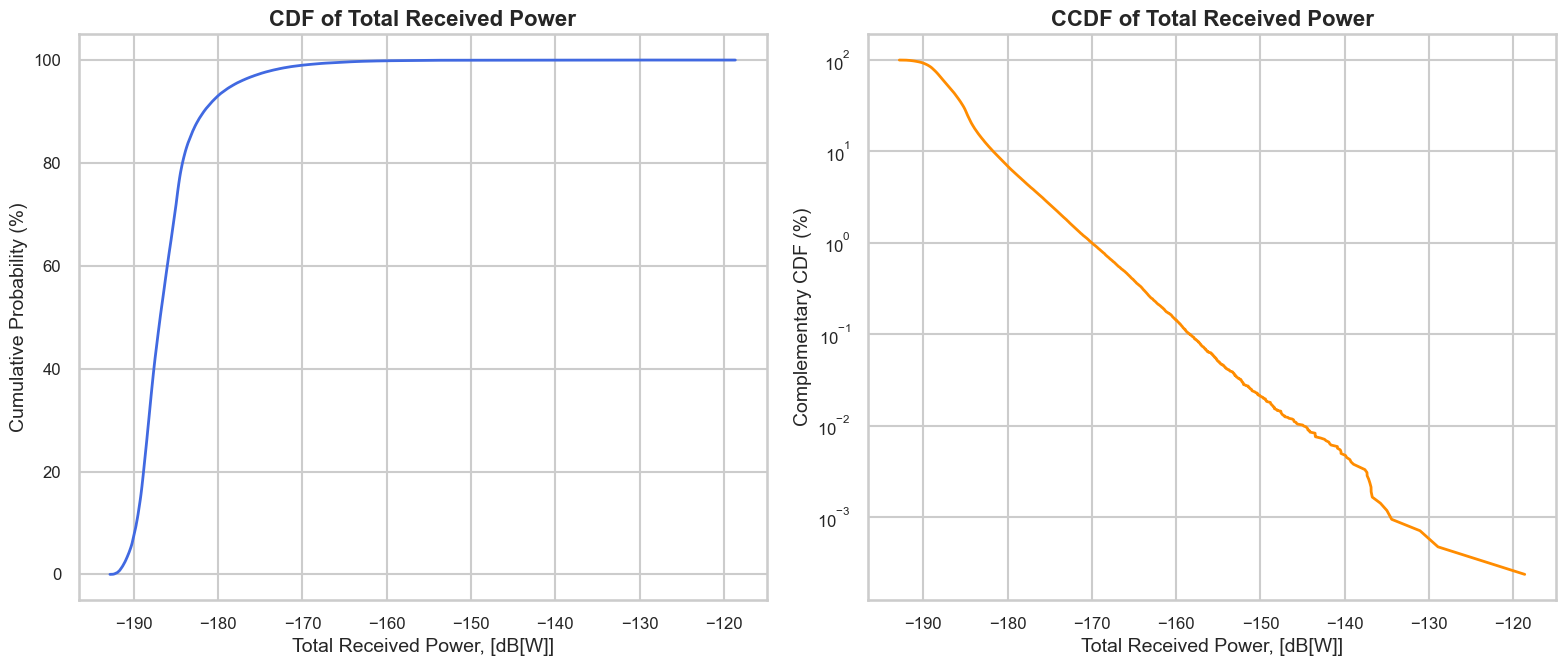

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distribution_curves(total_Prx_recovered, label="Total Received Power", unit_str="dB[W]", plot_type="both"):
    """
    Plot fancy distribution curves (CDF and/or CCDF) of the recovered total received power.
    
    Depending on the input parameter 'plot_type', this function will produce:
      - "cdf": a single-panel plot of the cumulative distribution function,
      - "ccdf": a single-panel plot of the complementary cumulative distribution function (with a log-scaled y-axis),
      - "both": a two-panel figure showing both curves side by side.
    
    Parameters
    ----------
    total_Prx_recovered : astropy.units.Quantity or ndarray
        The recovered total received power. If an astropy Quantity, its .value attribute is used.
    label : str, optional
        Label for the x-axis (e.g., "Total Received Power"). Default is "Total Received Power".
    unit_str : str, optional
        String representing the unit (e.g., "dB[W]"). Default is "dB[W]".
    plot_type : str, optional
        Which plot(s) to display:
            "cdf"   - only the CDF,
            "ccdf"  - only the CCDF,
            "both"  - both CDF and CCDF side-by-side (default).
    
    Returns
    -------
    None
        The function displays the generated plots.
    """
    # Process input: if total_Prx_recovered is an astropy Quantity, extract its value.
    try:
        data = total_Prx_recovered.value
    except AttributeError:
        data = np.array(total_Prx_recovered)
        
    # Flatten data into one dimension.
    data = data.flatten()
    
    # Sort the data.
    data_sorted = np.sort(data)
    N = len(data_sorted)
    
    # Calculate cumulative distribution and its complement.
    cdf = np.linspace(1./N, 1.0, N)
    ccdf = 1 - cdf + (1.0 / N)
    
    # Scale probabilities to percentages.
    cdf_percent = cdf * 100
    ccdf_percent = ccdf * 100
    
    # Use seaborn's set_theme for styling.
    sns.set_theme(style="whitegrid", context="talk")
    
    if plot_type not in ("cdf", "ccdf", "both"):
        raise ValueError("plot_type must be one of 'cdf', 'ccdf', or 'both'.")
        
    if plot_type == "both":
        fig, axes = plt.subplots(1, 2, figsize=(16, 7))
        
        # Plot CDF
        axes[0].plot(data_sorted, cdf_percent, linestyle='-', color='royalblue', linewidth=2)
        axes[0].set_title(f"CDF of {label}", fontsize=16, fontweight='bold')
        axes[0].set_xlabel(f"{label}, [{unit_str}]", fontsize=14)
        axes[0].set_ylabel("Cumulative Probability (%)", fontsize=14)
        axes[0].tick_params(axis='both', which='major', labelsize=12)
        
        # Plot CCDF
        axes[1].plot(data_sorted, ccdf_percent, linestyle='-', color='darkorange', linewidth=2)
        axes[1].set_title(f"CCDF of {label}", fontsize=16, fontweight='bold')
        axes[1].set_xlabel(f"{label}, [{unit_str}]", fontsize=14)
        axes[1].set_ylabel("Complementary CDF (%)", fontsize=14)
        axes[1].set_yscale("log")
        axes[1].tick_params(axis='both', which='major', labelsize=12)
        
        plt.tight_layout()
    
    elif plot_type == "cdf":
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.plot(data_sorted, cdf_percent, linestyle='-', color='royalblue', linewidth=2)
        ax.set_title(f"CDF of {label}", fontsize=16, fontweight='bold')
        ax.set_xlabel(f"{label} [{unit_str}]", fontsize=14)
        ax.set_ylabel("Cumulative Probability (%)", fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        plt.tight_layout()
    
    elif plot_type == "ccdf":
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.plot(data_sorted, ccdf_percent, linestyle='-', color='darkorange', linewidth=2)
        ax.set_title(f"CCDF of {label}", fontsize=16, fontweight='bold')
        ax.set_xlabel(f"{label} [{unit_str}]", fontsize=14)
        ax.set_ylabel("Complementary CDF (%)", fontsize=14)
        ax.set_yscale("log")
        ax.tick_params(axis='both', which='major', labelsize=12)
        plt.tight_layout()
    
    plt.show()

results = scenario.read_simulation_results(_STORAGE_FILENAME)
total_Prx_recovered=results["total_Prx"]
plot_distribution_curves(total_Prx_recovered.to(cnv.dB_W).value)

(181, 97, 1)


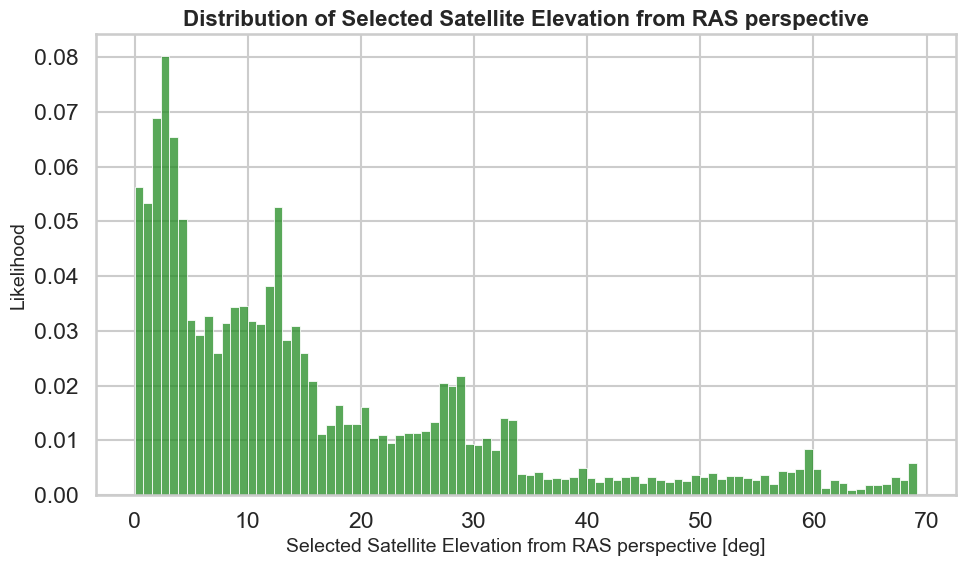

In [ ]:
results = scenario.read_simulation_results(_STORAGE_FILENAME)
selected_satellite_el_recovered=results["selected_satellite_el"]
print(selected_satellite_el_recovered.shape)


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy import units as u

def plot_selected_satellite_el_distribution(selected_satellite_el, 
                                              label="Selected Satellite Elevation", 
                                              unit_str="deg", 
                                              bins=30):
    """
    Plot the probability density distribution (PDF) for the selected satellite antenna elevation.

    Parameters
    ----------
    selected_satellite_el : astropy.units.Quantity or ndarray
        The recovered antenna elevation data.
    label : str, optional
        Label for the x-axis (default "Selected Satellite Elevation").
    unit_str : str, optional
        String representing the unit for display (default "deg").
    bins : int, optional
        Number of bins for the histogram (default 30).

    Returns
    -------
    None
        Displays the distribution plot.
    """
    # If selected_satellite_el is a Quantity, extract its value.
    try:
        data = selected_satellite_el.value
    except AttributeError:
        data = np.array(selected_satellite_el)
    
    # Flatten the data in case it is multidimensional.
    data = data.flatten()
    
    # Use seaborn's set_theme for a modern look.
    sns.set_theme(style="whitegrid", context="talk")
    
    # Create the plot.
    plt.figure(figsize=(10, 6))
    # Plot histogram with a KDE (density) overlay.
    sns.histplot(data, bins=bins, kde=False, color="forestgreen", stat="density")
    plt.title(f"Distribution of {label}", fontsize=16, fontweight="bold")
    plt.xlabel(f"{label} [{unit_str}]", fontsize=14)
    plt.ylabel("Likelihood", fontsize=14)
    plt.tight_layout()
    plt.savefig('EVELdistrMore0.png', bbox_inches='tight')
    plt.show()


# Example usage:
# Assuming you have already loaded your results and extracted:
# results = scenario.read_simulation_results(_STORAGE_FILENAME)
# selected_satellite_el_recovered = results["selected_satellite_el"]
#
# Then call:
plot_selected_satellite_el_distribution(selected_satellite_el_recovered[selected_satellite_el_recovered>0],
                                          label="Selected Satellite Elevation from RAS perspective",
                                          unit_str="deg",
                                          bins=90)

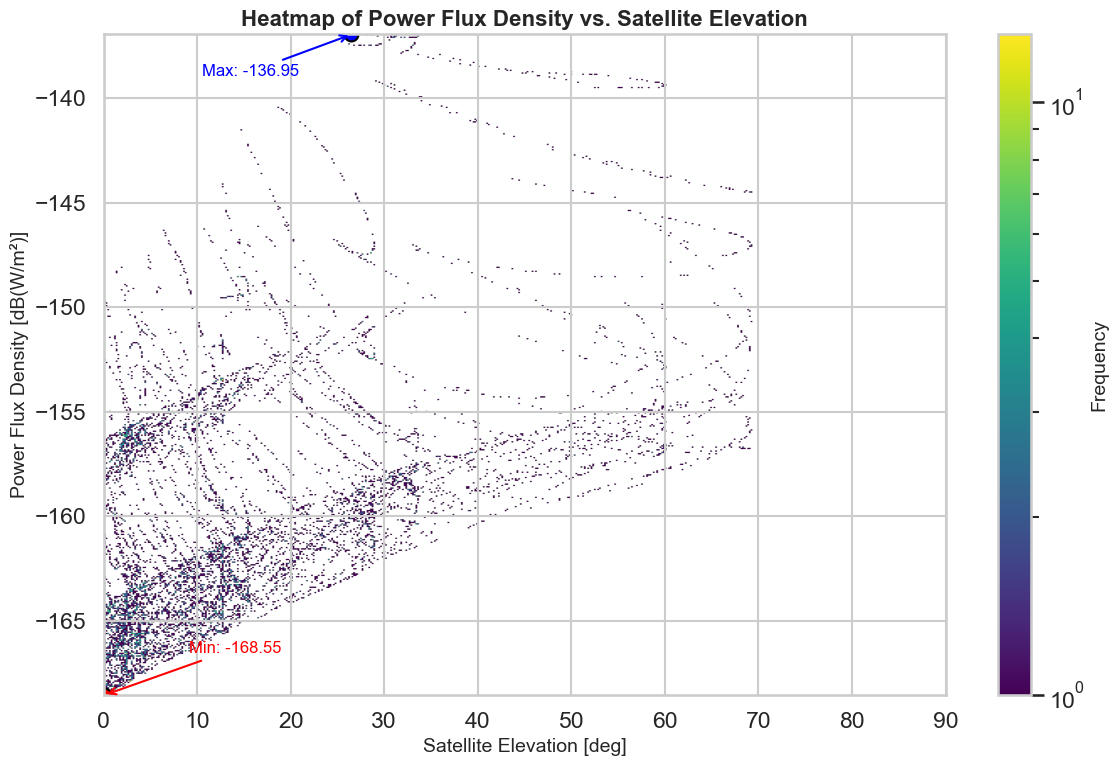

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from astropy import units as u

def plot_pfd_vs_elevation_heatmap(selected_satellite_el, powerflux_2RAS, 
                                  bins_elev=50, bins_pfd=50,
                                  elev_range=None, pfd_range=None,
                                  cmap="viridis", log_scale=False):
    """
    Creates a heatmap of the joint distribution of satellite elevation vs. power flux density,
    and overlays markers showing the global minimum and maximum power flux density values.

    Both inputs are assumed to have the same shape 
    (e.g., (timestamp, earthgrid_cell, Nco)). Each pair (satellite elevation, PFD) is taken as one observation.
    
    Parameters
    ----------
    selected_satellite_el : array-like or astropy.units.Quantity
        The selected satellite antenna elevation data (assumed in degrees).
    powerflux_2RAS : array-like or astropy.units.Quantity
        Power flux density values (assumed in dB(W/m²)).
    bins_elev : int, optional
        Number of bins along the satellite elevation axis (default 50).
    bins_pfd : int, optional
        Number of bins along the power flux density axis (default 50).
    elev_range : tuple of (float, float), optional
        The range for satellite elevation, in degrees. If None, the data range is used.
    pfd_range : tuple of (float, float), optional
        The range for power flux density, in dB(W/m²). If None, the data range is used.
    cmap : str, optional
        Colormap to use (default "viridis").
    log_scale : bool, optional
        If True, the frequency (counts) axis uses logarithmic normalization. Default is False.
    
    Returns
    -------
    H : ndarray
        The 2D histogram array.
    xedges, yedges : ndarray
        The bin edges along the elevation and power flux density axes.
    """
    # If inputs are astropy Quantities, extract their numeric values.
    try:
        elev_data = selected_satellite_el.value
    except AttributeError:
        elev_data = np.array(selected_satellite_el)
    
    try:
        pfd_data = powerflux_2RAS.value
    except AttributeError:
        pfd_data = np.array(powerflux_2RAS)
    
    # Flatten the arrays so that each observation is a pair.
    elev_flat = elev_data.flatten()
    pfd_flat = pfd_data.flatten()
    
    # Determine the range for each axis if not provided.
    if elev_range is None:
        elev_range = (np.nanmin(elev_flat), np.nanmax(elev_flat))
    if pfd_range is None:
        pfd_range = (np.nanmin(pfd_flat), np.nanmax(pfd_flat))
        
    # Compute the 2D histogram.
    H, xedges, yedges = np.histogram2d(elev_flat, pfd_flat, bins=[bins_elev, bins_pfd],
                                      range=[elev_range, pfd_range])
    # Note: np.histogram2d returns H where rows correspond to x-axis bins and columns to y-axis.
    # For imshow, we want the y-axis corresponding to pfd, so we transpose H.
    H = H.T

    # Set up seaborn theme.
    sns.set_theme(style="whitegrid", context="talk")
    plt.figure(figsize=(12, 8))
    
    # Define plot extent using bin edges.
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    # Choose normalization for the heatmap.
    norm = LogNorm() if log_scale else None
    
    # Create the heatmap using imshow.
    ax = plt.gca()
    im = ax.imshow(H, aspect="auto", origin="lower", extent=extent,
                   cmap=cmap, norm=norm)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Frequency", fontsize=14)

    # Overlay markers for the global min and max power flux density.
    min_idx = np.argmin(pfd_flat)
    max_idx = np.argmax(pfd_flat)
    x_min, y_min = elev_flat[min_idx], pfd_flat[min_idx]
    x_max, y_max = elev_flat[max_idx], pfd_flat[max_idx]
    
    # Plot minimum as a red circle, maximum as a blue circle.
    ax.scatter(x_min, y_min, s=100, c="red", marker="o", edgecolors="black", label="Min PFD")
    ax.scatter(x_max, y_max, s=100, c="blue", marker="o", edgecolors="black", label="Max PFD")
    
    # Annotate the values near the markers.
    ax.annotate(f"Min: {y_min:.2f}", xy=(x_min, y_min), xytext=(x_min+9, y_min+2),
                arrowprops=dict(arrowstyle="->", color="red"), fontsize=12, color="red")
    ax.annotate(f"Max: {y_max:.2f}", xy=(x_max, y_max), xytext=(x_max-16, y_max-2),
                arrowprops=dict(arrowstyle="->", color="blue"), fontsize=12, color="blue")
    
    # Label axes with units.
    ax.set_xlabel("Satellite Elevation [deg]", fontsize=14)
    ax.set_ylabel("Power Flux Density [dB(W/m²)]", fontsize=14)
    ax.set_title("Heatmap of Power Flux Density vs. Satellite Elevation", fontsize=16, fontweight="bold")
    
    plt.tight_layout()
    plt.savefig('PFDvsSatElev.png', bbox_inches='tight')
    plt.show()
    
    # return H, xedges, yedges



results = scenario.read_simulation_results(_STORAGE_FILENAME)
selected_satellite_el_recovered = results["selected_satellite_el"]
powerflux_2RAS_recovered = results["powerflux_2RAS"]
# # Plot with linear frequency scale:
# plot_pfd_vs_elevation_heatmap(selected_satellite_el_recovered, powerflux_2RAS_recovered, 
#                               bins_elev=50, bins_pfd=50, elev_range=(0,90), log_scale=False)


# Or, to plot with a logarithmic frequency scale:
window_size = int(1000 / timestep)
from scipy.ndimage import uniform_filter1d
smoothed_pfd = 10 * np.log10 (uniform_filter1d(10 ** (powerflux_2RAS_recovered.value / 10), size=window_size))

# plot_pfd_vs_elevation_heatmap(selected_satellite_el_recovered[selected_satellite_el_recovered>0], powerflux_2RAS_recovered[selected_satellite_el_recovered>0], 
#                               bins_elev=500, bins_pfd=500, elev_range=(0,max_deviation_angle.to(u.deg).value), log_scale=True)
plot_pfd_vs_elevation_heatmap(selected_satellite_el_recovered[selected_satellite_el_recovered>0], smoothed_pfd[selected_satellite_el_recovered>0], 
                              bins_elev=500, bins_pfd=500, elev_range=(0,90), log_scale=True)